# Model Mechanism of K-Pattern Formation in Crystals

## Abstract

This is a self-contained notebook demonstrating central aspects of coherence loss and the resulting transition from spot-like diffraction diffraction patterns which are related to momentum transfer from a crystal to an incident plane wave beam as compared to incoheretn diffraction patterns which have lost coherence to the incident plane wave beam.

## Ancillary Code

These imports and definitions are necessary for running the notebook. 

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
import numpy as np
import numpy.testing as npt
import math as m
import cmath as cma
import os
import sys
import shutil
import time
import pprint
import gc

# get the base directory of this notebook (at start)
if not 'BaseDir' in globals():
    BaseDir =os.getcwd()
print(BaseDir)

f:\OneDrive\Work\mypapers\codes\twice\src


In [2]:
def gotoworkdir(DirName=None):
    """
    - set up and change to a working directory based on the current time
    - archive the current files
    
    needs:
        import os, shutil,time

    """
   
    # test if "results" subdir exists
    if not os.path.isdir('runs'):
        os.mkdir('runs')
    if DirName==None:
        # now the working directory for the current simulation, name based on time
        workdir="runs/"+str(time.localtime().tm_mon).zfill(2)+'_' \
            +str(time.localtime().tm_mday).zfill(2)+'_' \
            +str(time.localtime().tm_hour).zfill(2) \
            +str(time.localtime().tm_min).zfill(2) \
            +str(time.localtime().tm_sec).zfill(2)
    else:
        workdir="runs/"+DirName
        
    print("simulation run results directory: ",workdir)
    if os.path.isdir(workdir):
        shutil.rmtree(workdir)
    os.mkdir(workdir)
    # make backup directory for respective python code
    os.mkdir(workdir+'/py')
    os.mkdir(workdir+'/png')
    os.mkdir(workdir+'/pdf')
    os.mkdir(workdir+'/ss')
    os.mkdir(workdir+'/ds')
    # archive copies of the current files and python codes
    src_files = os.listdir(os.curdir)
    for file_name in src_files:
        full_file_name = os.path.join(os.curdir, file_name)
        if (os.path.isfile(full_file_name)):
            shutil.copy(full_file_name, workdir+'/py')
    # change into working directory
    os.chdir(workdir)

In [3]:
# reading atom coordinates from xyz file
# structure: ZA  X  Y Z 
def readcluster(filename):
  print("reading z xyz cluster file:", filename)
  with open(filename) as f:
    natoms = [int(x) for x in f.readline().split()] # read first line
    comment =f.readline() # comment 
    natoms=natoms[0]
    print(natoms)
    print(comment)
    array = []
    for line in f: # read rest of lines
        array.append([float(x) for x in line.split()])
  f.close
  npa=np.asarray(array)

  zs   =np.zeros(natoms,dtype=np.integer) 
  atoms=np.zeros((natoms,3),dtype=np.float)

  zs=npa[:,0] # zvalues in first column
  atoms=npa[:,1:4] # xyz in the next columns
  return natoms,zs,atoms

In [4]:
def Rx(RotAngle):
    '''
    provides the X axis (e1) rotation matrix in cartesian systems,
    input "RotAngle" in radians

    meaning for a COLUMN of VECTORS: transformation matrix U for VECTORS
    this matrix rotates a set of "old" basis vectors 
    $(\vec{e1},\vec{e2},\vec{e3})^T$ (column) by +RotAngle (right hand rule) 
    to a new set of basis vectors $(\vec{e1}',\vec{e2}',\vec{e3}')^T$ (column)

    meaning for a COLUMN of vector COORDINATES:
    (1) (N_P_O):    coordinates of fixed vector in a "new" basis that is 
                    rotated by +RotAngle (passive rotation)
    (2) (O_P_O):    active rotation of vector coordinates in the same 
                    "old" basis by -RotAngle
    '''
    mat=np.matrix([ [1,                 0,               0 ],
                    [0,  np.cos(RotAngle), np.sin(RotAngle)],
                    [0, -np.sin(RotAngle), np.cos(RotAngle)]])
    return mat
#------------------------------------------------------------------------------


#------------------------------------------------------------------------------
def Rz(RotAngle):
    '''
    provides the Z axis (e3) rotation matrix in cartesian systems,
    input "RotAngle" in radians

    meaning for a COLUMN of VECTORS: transformation matrix U for VECTORS
    this matrix rotates a set of "old" basis vectors 
    $(\vec{e1},\vec{e2},\vec{e3})^T$ (column) by +RotAngle (right hand rule) 
    to a new set of basis vectors $(\vec{e1}',\vec{e2}',\vec{e3}')^T$ (column)

    meaning for a COLUMN of vector COORDINATES:
    (1) (N_P_O):    coordinates of fixed vector in a "new" basis that is 
                    rotated by +RotAngle (passive rotation)
    (2) (O_P_O):    active rotation of vector coordinates in the same 
                    "old" basis by -RotAngle
    '''
    mat=np.matrix([[ np.cos(RotAngle) , np.sin(RotAngle), 0 ],
                   [-np.sin(RotAngle) , np.cos(RotAngle), 0 ],
                   [                0 ,                0, 1 ]])
    return mat
#------------------------------------------------------------------------------




def make_cluster(rmax=6.4,FileName=None,phi1=0.0,PHI=0.0,phi2=0.0):
    """
     creates a list of atomic coordinates 
     from a definition of a unit cell 
    """

    print('-----------------------------------------------------------------')
    print('creating atomic coordinates for cluster')
    print('-----------------------------------------------------------------')

    a=3.0
    b=3.0
    c=3.0
    alpha=90
    beta=90
    gamma=90
    ncells=5   # number of +/- repeats of unit cells for cluster

    # cluster radius TEST VALUES: 
    #rmax=2.5 # 9 -atom bcc unit cell
    #rmax=2.9 # 15-atom next nearest  
    #rmax=6.4 # 89 atoms
    #rmax=8.4 # 181 atoms 
    #rmax=9.0 #259 atoms

    # create basis atoms for unit cell
    BasisAtoms=[]
    BasisAtoms.append(['Fe',26,1.0,0.5,0.5,0.5]) # fractional coo
    BasisAtoms.append(['Fe',26,1.0,0.0,0.0,0.0]) # fractional coo
    LatticeParams=[a,b,c,alpha,beta,gamma]

    # rotation matrix
    U = Rz(phi2)  * Rx(PHI) * Rz(phi1)
    
    print('creating list of scatterers...')
    atoms=[]
    zs=[]
    count=0
    for ia in range(-ncells,ncells+1):
        for ib in range(-ncells,ncells+1):
            for ic in range(-ncells,ncells+1):
                rLattice = [ia*a,ib*b,ic*c]
                for iBase in range(0, len(BasisAtoms)):
                    #cart.coo =  r0      + repeated lattice + basis
                    x0=np.float(rLattice[0]+BasisAtoms[iBase][3]*a)
                    y0=np.float(rLattice[1]+BasisAtoms[iBase][4]*b)
                    z0=np.float(rLattice[2]+BasisAtoms[iBase][5]*c)
                    
                    XYZ0=np.array((x0,y0,z0))
                    
                    XYZ=np.dot(U.T, XYZ0)
                    
                    x=XYZ[0,0]
                    y=XYZ[0,1]
                    z=XYZ[0,2]
                    
                    #spherical cluster
                    rxy=m.sqrt(x**2+y**2+z**2)
                    if (rxy<=rmax):
                      atoms.append(np.array((x,y,z)))
                      zs.append(BasisAtoms[iBase][1])
                      #print count, zs[count], atoms[count]
                      count+=1

    # calculation below needs: atoms,natoms,(zs),sqn
    atoms=np.asarray(atoms)
    zs=np.asarray(zs)
    natoms=len(atoms)
    print('(make_cluster) number of atoms: '+str(natoms))

    if (FileName!=None):
        # save all coordinates to .xyz-file for Jmol viewer
        ofile=open(FileName,'w')
        ofile.write('%i \n' % natoms)
        ofile.write('make_cluster: atom cluster for >twice<\n')
        for i in range(atoms.shape[0]):
            ofile.write('%5i %10.6f %10.6f %10.6f \n' % (zs[i],atoms[i,0],atoms[i,1],atoms[i,2]) )
            ofile.flush()
        ofile.close
        
    return natoms,atoms,zs

In [5]:
# normalize a vector v
def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0: 
       return v
    return v/norm

def SSquare_NP(k_init,k_final):
    svec=0.5*(k_final-k_init)
    ss  =np.linalg.norm(svec,axis=1)**2
    return ss[:,np.newaxis]

def SSquare(k_init,k_final):
    svec=0.5*(k_final-k_init)
    ss  =np.inner(svec,svec)
    return ss

def thetaScatt(s,k):
    """ returns scattering angle in rad 
    input: $s=(\Delta k)/2$ and wave vector k
    """
    theta=2.0*np.arcsin(s/k)
    return theta

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = normalize(v1)
    v2_u = normalize(v2)
    angle = np.arccos(np.dot(v1_u, v2_u))
    if np.isnan(angle):
        if (v1_u == v2_u).all():
            return 0.0
        else:
            return np.pi
    return angle

def cos_angle_between(v1, v2):
    v1_u = normalize(v1)
    v2_u = normalize(v2)
    cos_angle=np.dot(v1_u, v2_u)
    return cos_angle


In [6]:
def plot_screen2(ImageMatrix1,ImageMatrix2,params,
                 kxmin,kxmax,kymin,kymax,datnum,
                 FixVLim=None,FixVmin=None,
                 Animation=False,
                 dpi=300,
                 DrawCircles=False):
    """
    makes two 2D image plots
    """
    # Matplotlib option: set ticks outside of axis in plot
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    #mpl.rcParams['figure.figsize'] = 11,5  
    
    # get maximum intensity
    max1=np.max(ImageMatrix1)
    max2=np.max(ImageMatrix2)
    
    # get minimum intensity
    min1=np.min(ImageMatrix1)
    min2=np.min(ImageMatrix2)
    
    
    
    if (FixVLim==None):
        MaxValue=np.max(np.array([max1,max2]))
    else:
        MaxValue=FixVLim    
   
    if (FixVmin==None):
        MinValue=np.min(np.array([min1,min2]))
    else:
        MinValue=FixVmin    
   
    dI=(MaxValue-MinValue)
    if (FixVLim==None):
        MaxValue=MaxValue-0.15*dI
    if (FixVmin==None):
        MinValue=np.max(np.array([MinValue-0.15*dI,0.0]))
    
    #plt.figure()
    x= plt.figure(figsize=(11,5), dpi=dpi)
    plt.subplots_adjust(wspace=0.15,top=0.85,left=0.08,hspace=0.05,right=0.92)    
    ax = plt.subplot(121)
    ax.set_aspect('equal')
    extent = [kxmin,kxmax,kymin,kymax] 
    #colormap=cm.gray_r # or cm.spectral
    colormap=cm.gray
    #colormap=cm.spectral
    #plt.imshow(Idiff, extent=extent, interpolation='nearest',cmap=cm.spectral)
    plt.imshow(ImageMatrix1, extent=extent, interpolation='nearest',
               cmap=colormap,vmax=MaxValue,vmin=MinValue) 
    plt.title('single scattering',fontsize=12,y=1.02)
    plt.xlim(kxmin,kxmax)    # y-axis of sample
    plt.ylim(kymin,kymax)   # z-axis of sample
    plt.xlabel(r"$X_S$",fontsize=14,labelpad=5) # labelpad is offset
    plt.ylabel(r"$Y_S$",fontsize=14,labelpad=5)
    #set color bar to same height as plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb=plt.colorbar(cax=cax)
    #cb.set_label('intensity')
    
    # text in axes coords
    if not params['SystemTitle'] == None:
        ax.text(0.0, 1.12, r'%(SystemTitle)s' % params,
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='black', fontsize=12, fontweight='normal')
    

    ax = plt.subplot(122)
    ax.set_aspect('equal')
    extent = [kxmin,kxmax,kymin,kymax] 
    
    #ExperimentalImage = image.imread('c:/temp/bcc9.png')
    #plt.imshow(ExperimentalImage,  #aspect=1.0,
    #       extent=(-1.5,1.5,-1.5,1.5), alpha=1.0, zorder=-1)
    
    
    #colormap=cm.gray_r # or cm.spectral
    colormap=cm.gray
    #colormap=cm.spectral
    plt.imshow(ImageMatrix2, extent=extent, interpolation='nearest',
               cmap=colormap,vmax=MaxValue,vmin=MinValue) 
    #------------------------------------------------------------------------------
    # draw circles for angular distances from center
    if DrawCircles:
        for ThetaGnom in range(0,141,10):       
            circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*ThetaGnom)),
                           alpha=1.0,edgecolor='w',facecolor='None',linewidth=1)
            plt.gcf().gca().add_artist(circle1)  
        # Hemisphere Circle    
        circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*90.0)),
                           alpha=1.0,edgecolor='b',facecolor='None',linewidth=3)
        plt.gcf().gca().add_artist(circle1)      
    #------------------------------------------------------------------------------   
    
    plt.title('double scattering',fontsize=12,y=1.02)
    plt.xlim(kxmin,kxmax)    # y-axis of sample
    plt.ylim(kymin,kymax)   # z-axis of sample
    plt.xlabel(r"$X_S$",fontsize=14,labelpad=5) # labelpad is offset
    #plt.ylabel(r"$k_y (1/\AA)$",fontsize=14,labelpad=5)
    #set color bar to same height as plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb=plt.colorbar(cax=cax)
    cb.set_label('intensity')

  
    CountStr='_'+str(datnum).zfill(3)
    if os.path.isdir("pdf"):
        plt.savefig('pdf/'+params["FilePrefix"]+CountStr+'.pdf',
                dpi=dpi)#,bbox_inches='tight')
    if os.path.isdir("png"):    
        plt.savefig('png/'+params["FilePrefix"]+CountStr+'.png',
                dpi=dpi)#,bbox_inches='tight')

    if Animation:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()
    else:
        plt.show() 
      
    del x
    gc.collect()
    return 



def plot_structure(ImageMatrix1,ImageMatrix2,params,
                 kxmin,kxmax,kymin,kymax,datnum,
                 FixVLim=None,FixVmin=None,
                 Animation=False):
    """
    makes two 2D image plots
    """
    # Matplotlib option: set ticks outside of axis in plot
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    #mpl.rcParams['figure.figsize'] = 11,5  
    
    # get maximum intensity
    max1=np.max(ImageMatrix1)
    max2=np.max(ImageMatrix1)
    
    # get minimum intensity
    min1=np.min(ImageMatrix1)
    min2=np.min(ImageMatrix1)
    
    
    
    if (FixVLim==None):
        MaxValue=np.max(np.array([max1,max2]))
    else:
        MaxValue=FixVLim    
   
    if (FixVmin==None):
        MinValue=np.min(np.array([min1,min2]))
    else:
        MinValue=FixVmin    
    
    dI=(MaxValue-MinValue)
    if (FixVLim==None):
        MaxValue=MaxValue-0.15*dI
    if (FixVmin==None):
        MinValue=MinValue-0.15*dI


    #plt.figure()
    x=plt.figure(figsize=(11,5), dpi=600)
    plt.subplots_adjust(wspace=0.15,top=0.85,left=0.08,hspace=0.05,right=0.92)    
    ax = plt.subplot(121)
    ax.set_aspect('equal')
    extent = [kxmin,kxmax,kymin,kymax] 
    #colormap=cm.gray_r # or cm.spectral
    colormap=cm.gray
    #colormap=cm.spectral
    #plt.imshow(Idiff, extent=extent, interpolation='nearest',cmap=cm.spectral)
    plt.imshow(ImageMatrix1, extent=extent, interpolation='nearest',
               cmap=colormap,vmax=MaxValue,vmin=MinValue) 
    plt.title('diffraction pattern',fontsize=12,y=1.02)
    plt.xlim(kxmin,kxmax)    # y-axis of sample
    plt.ylim(kymin,kymax)   # z-axis of sample
    plt.xlabel(r"$X_S$",fontsize=14,labelpad=5) # labelpad is offset
    plt.ylabel(r"$Y_S$",fontsize=14,labelpad=5)
    #set color bar to same height as plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb=plt.colorbar(cax=cax)
    #cb.set_label('intensity')
    
    # text in axes coords
    if not params['SystemTitle'] == None:
        ax.text(0.0, 1.12, r'%(SystemTitle)s' % params,
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            color='black', fontsize=12, fontweight='normal')
    

    ax = plt.subplot(122)
    ax.set_aspect('equal')
    extent = [kxmin,kxmax,kymin,kymax] 
    
    #colormap=cm.gray_r # or cm.spectral
    colormap=cm.gray
    #colormap=cm.spectral
    plt.imshow(ImageMatrix2, extent=extent, interpolation='nearest',
               cmap=colormap,vmax=MaxValue,vmin=MinValue) 
    plt.title('structure view',fontsize=12,y=1.02)
    plt.xlim(kxmin,kxmax)    # y-axis of sample
    plt.ylim(kymin,kymax)   # z-axis of sample
    plt.xlabel(r"$X_S$",fontsize=14,labelpad=5) # labelpad is offset
    #plt.ylabel(r"$k_y (1/\AA)$",fontsize=14,labelpad=5)
    #set color bar to same height as plot
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb=plt.colorbar(cax=cax)
    #cb.set_label('intensity')
    
    # Hemisphere Circle    
    circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*90.0)),
                       alpha=0.5,edgecolor='w',facecolor='None',
                       linewidth=4, linestyle='dashed')
    plt.gcf().gca().add_artist(circle1)   
    circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*54.7)),
                       alpha=0.3,edgecolor='w',facecolor='None',
                       linewidth=2, linestyle='dashed')
    plt.gcf().gca().add_artist(circle1)   
    circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*(180.0-54.7))),
                       alpha=0.3,edgecolor='w',facecolor='None',linewidth=2)
    plt.gcf().gca().add_artist(circle1)        



    CountStr='_'+str(datnum).zfill(3)
    if os.path.isdir("pdf"):
        plt.savefig('pdf/'+params["FilePrefix"]+CountStr+'.pdf',
                dpi=300)#,bbox_inches='tight')
    if os.path.isdir("png"):    
        plt.savefig('png/'+params["FilePrefix"]+CountStr+'.png',
                dpi=300)#,bbox_inches='tight')

    if Animation:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()
    else:
        plt.show() 
    
    del x
    gc.collect()
    return 


### Scattering Factors

We use the parameterization of the electron scattering according to Peng et al.

In [7]:
def fPeng(s_square):
    ''' electron scattering factor for scattering vector s_scatt in 1/A
    '''
    Label='Fe'
    Z= 26  
    A=np.array([0.3946, 1.2725, 1.7031, 2.3140, 1.4795])
    B=np.array([0.2717, 2.0443, 7.6007, 29.9714, 86.2265])
    fE=np.sum(A*np.exp(-s_square*B))
    return fE

def fPeng_NP(s_square):
    ''' electron scattering factor for scattering vector s_scatt in 1/A
    '''
    Label='Fe'
    Z= 26  
    A=np.array([0.3946, 1.2725, 1.7031, 2.3140, 1.4795])
    B=np.array([0.2717, 2.0443, 7.6007, 29.9714, 86.2265])
    Bexp=np.exp(-s_square*B)
    fE=np.sum(A*Bexp,axis=1)
    return fE

def fScatt_NP(s_square):
    ''' general electron scattering factors for numpy array of scattering vector^2 
    '''
    global fScattStrength,fScattWidth
    #fE=0.2*fPeng_NP(0.05*s_square)
    # 0.13959266859304548 makes Peng(0) =1.0
    fE=fScattStrength*0.13959*fPeng_NP(fScattWidth*s_square) 
    #fE=0.01*fPeng_NP(0.00005*s_square) # s-wave out 
    return fE

In [8]:
def calc_wave_k(KineticEnergy):
    """ 
    returns wave vector of electron with keV energy 
    wave vector is 2*Pi/WaveLength in 1/Angströms   
    Formula: $E_{kin}=\hbar^2 k^2/(2*m_e)$
    """
    return 0.5123*m.sqrt(KineticEnergy)

In [9]:
1/fPeng(0)

0.13959266859304548

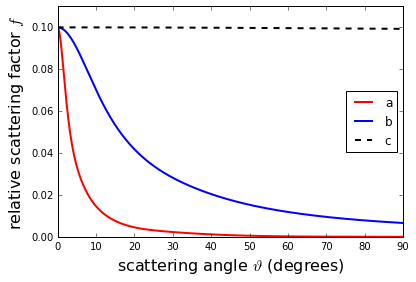

In [12]:
nPoints=10000
theta = np.linspace(0.0,180.0,nPoints)    
kwave=5.0*2.0*m.pi
ss2=(kwave*np.sin(0.5*theta*m.pi/180.0))**2    
    
    
# scattering factor which emphasizes rings 
fScattStrength=0.1 
fScattWidth=0.002   
fDimer=fScatt_NP(ss2[:,np.newaxis])#/fScatt_NP(np.zeros(nPoints)[:,np.newaxis])    

# scattering factor which approximates Kikuchi band scenario 
fScattStrength=0.1
fScattWidth=0.05   
fKiku=fScatt_NP(ss2[:,np.newaxis])#/fScatt_NP(np.zeros(nPoints)[:,np.newaxis])  

# scattering factor which approximates Neutron scenario 
fScattStrength=0.1
fScattWidth=0.0000005   
fNeutron=fScatt_NP(ss2[:,np.newaxis])#/fScatt_NP(np.zeros(nPoints)[:,np.newaxis])

    
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
axes.plot(theta, fKiku, 'r',linewidth=2,label='a')
axes.plot(theta, fDimer, 'b',linewidth=2, label='b')
axes.plot(theta, fNeutron, 'k',linewidth=2,linestyle='dashed',label='c')
axes.legend(loc='center right')
#axes.plot(x, y3, 'g')
axes.set_xlabel(r'scattering angle $\vartheta$ (degrees)', fontsize=16)
axes.set_ylabel(r'relative scattering factor $f$', fontsize=16)
axes.set_ylim(0,0.11)
axes.set_xlim(0,90)
#axes.set_title('scattering factors for second scattering event') 
plt.savefig('fig/fscattering.pdf',dpi=150,bbox_inches='tight')


## Definitions

In [11]:
def calc_coherence_matrix(Ratoms,coherence_length,randomFactor=0.0):
    """
    damping of coherence between atom i and atom j
    input: 
        coordinates of atoms in cluster
        cohrence_length: exponential damping length of coherence
    output: 
        aij: coherence factors aii=1
    """
    print('Calculation of coherence matrix...')
    print('Coherence Length: '+str(coherence_length))
    number_of_atoms=Ratoms.shape[0]
    aij       =np.ones((number_of_atoms,number_of_atoms  ),dtype=np.complex128)
    phase     =np.zeros((number_of_atoms,number_of_atoms  ),dtype=np.float64)
    # loop not vectorized since this is needed only once  
    for i in range(number_of_atoms):
        for j in range(number_of_atoms):
            Rij=np.linalg.norm(Ratoms[j]-Ratoms[i])
            aij[i,j]=np.exp(-Rij/coherence_length)
            #aij[i,j]=1.0 
            
    # random phase factors
    # diagonal terms not shifted
    #for i in range(number_of_atoms):
    #     phase[i,i]=0.0;
    # first row and column are the free parameters
    for i in range(1,number_of_atoms):
        phase[0,i]= randomFactor*2.0*np.pi*np.random.random_sample()
        phase[i,0]=-phase[0,i]
    # other values must be differences
    for jrow in range(1,number_of_atoms):    
        for icol in range(jrow+1,number_of_atoms):
            phase[jrow,icol]= phase[0,icol]-phase[0,jrow]
            phase[icol,jrow]=-phase[jrow,icol]
            
    # apply random phases
    aij*=np.exp(1.0j*phase)
    
    #pprint.pprint(aij)
    #pprint.pprint(phase*180.0/np.pi)
    #raw_input('phase Matrix')            
    return aij

In [12]:
def calc_propagator_matrix(kG,Ratoms):
    """
    calculates wave propagator from atom i to atom j
    input: 
        kG : wave number = 2 Pi / WaveLength
        Ratoms: coordinates of point sources in cluster
    output: 
        Gij:Propagation factor of spherical wave from
            point source at Ratoms[i] to point at Ratoms[j]
    """
    print("Calculation of propagator structure matrix...")
    NAtoms=Ratoms.shape[0]
    Gij       =np.zeros((NAtoms,NAtoms  ),dtype=np.complex128)
    Gij_final =np.zeros((NAtoms,NAtoms-1),dtype=np.complex128)
    
    Kij       =np.zeros((NAtoms,NAtoms  ,3),dtype=np.float64)
    Kij_final =np.zeros((NAtoms,NAtoms-1,3),dtype=np.float64)
    
    # loop not vectorized yet since this is needed only once per cluster and energy(=k) 
    for i in range(NAtoms):
        for j in range(NAtoms):
            if (i != j):
                rml_v= Ratoms[j]-Ratoms[i]
                rml  =np.linalg.norm(rml_v) # length
                rml_u=rml_v/rml
                Kij[i,j]=kG*rml_u             
                Gij[i,j]=np.exp(-1.0j*kG*rml)/rml        
            else:
                Kij[i,j]=0.0
                Gij[i,j]=0.0+0.0j
                
    # no self scattering:
    # waves will always go to an atom j different from the current one i 
    # so we only save i!=j values in the final Gij matrix 
    for idxSource in range(NAtoms):
        Gij_final[idxSource]=np.delete(Gij[idxSource,:],idxSource,0)
        Kij_final[idxSource]=np.delete(Kij[idxSource,:],idxSource,0)
    return Gij_final,Kij_final

In [13]:
def KSourceWave(k_in,k_out,RSource,RScatt,idxSource,Gmn):
    '''
    calculates wavefunction 
    of a point source at RSource 
    after scattering at surrounding atomns RScatt
    outgoing direction k_out
    incident scattering from direction k_in
    '''
    # single scattering pathway from Rsource
    fm=1.0 # isotropic direct scattering
    A1m=fm*np.exp(+1.0j*(np.dot(k_out, RSource)))
    
    # double scattering pathways:
    # first scattering isotropic
    fmn=1.0 
    # second scattering factor
    s_square_A=SSquare_NP(k_out,Kij[idxSource])
    fnk=fScatt_NP(s_square_A)
    # final phase at second scattering plave RScatt
    Aout=np.exp(+1.0j*(np.inner(k_out , RScatt))) 
   
    A2m  = np.sum(fmn * Gmn[idxSource] * fnk * Aout)
    A2m += A1m # sum of SS and DS
    
    return A2m,A1m # ss+ds, ss

In [14]:
def CalcDoubleScattering(k_in,k_out,R_atom,Phases,Gij):
    """ 
      calculates single and double scattering wave functions
      
      input:  - k_in,k_out incident and exit wave vectors
              - R_atom cluster atoms [x,y,z] coordinates
              - Phases: random phase offset of incident beam for each atom
              - Gij : propagator matrix from atom i to atom j
             
      output: - psi1C : single scattering wave from atom i       
              - psi2C : double scattering sum wave from atom i to atoms j<>i
              - Gk0   : incident beam propagator (with additional Phases from input)
    """
  
    # wave functions for each atom for trajectory k_in -> k_out  
    psi1C=np.zeros(R_atom.shape[0],dtype=np.complex128) 
    psi2C=np.zeros(R_atom.shape[0],dtype=np.complex128)    
    # phase of incident beam at atom
    Gk0=np.zeros((1,R_atom.shape[0]),dtype=np.complex128)    
    
    # consider each atom in the cluster separately as primary source  
    for mi in range(R_atom.shape[0]):   
        RSource=R_atom[mi]
        # incident wave phase on each cluster atom
        # this will be the point for explicitly randomized phases for Kikuchi-Pattern formation
        # compare to the coherence matrix approach further down
        Gk0[0,mi]=np.exp(-1.0j*(np.dot(k_in , RSource)   )) #+Phases[mi] ))

        # SINGLE + DOUBLE SCATTERING OUTGOING WAVE
        # loop over all second scatterers
        # make list of all allowed 2nd scatterers: remove source atom
        RScattArray=np.delete(R_atom,mi,0)
        # wave functions for each cluster atom
        psi2C[mi] , psi1C[mi]  = KSourceWave(k_in,k_out,RSource,RScattArray,mi,Gij) # final double scattered wave

    psi1C=np.expand_dims(psi1C, axis=0)
    psi2C=np.expand_dims(psi2C, axis=0)
    
    return psi1C,psi2C,Gk0

### Diffraction Data Visualization

The final diffraction pattern consist of the intensities at the outgoing wave vectors $\vec{k}_{out}$. These wave vectors are calculated for a specified projection of the data, which can be linear in reciprocal space or in a stereographic projection: 

In [15]:
def getGnomonicLimits():
    # Pattern Center
    BRKR_DD =0.79875 # in units of screen height
    BRKR_PCX=0.48546 # in units of screen width, from left of exp. pattern
    BRKR_PCY=0.12820 # in units of screen height, from top of exp. pattern

    # Screen, only the Aspect Ratio is important here
    BRKR_ScreenWidth=320
    BRKR_ScreenHeight=230

    # limits of gnomonic projection
    ScreenAspect=float(BRKR_ScreenWidth)/float(BRKR_ScreenHeight)
    y_gn_max= + (    BRKR_PCY)              /BRKR_DD
    y_gn_min= - (1.0-BRKR_PCY)              /BRKR_DD
    x_gn_max= +((1.0-BRKR_PCX)*ScreenAspect)/BRKR_DD
    x_gn_min= -((    BRKR_PCX)*ScreenAspect)/BRKR_DD 
    
    return x_gn_min,x_gn_max,y_gn_min,y_gn_max
    
    
def make_trajectory_list(k0,theta,phi,kout_npix,kscale,Projection='stereo'):
    """ calculate incoming and outgoing k-vectors
    """
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale
    
    # uncomment for gnomonic projection
    #kxmin,kxmax,kymin,kymax=getGnomonicLimits()
        
    dkx=(kxmax-kxmin)/(kout_npix-1)
    dky=(kymax-kymin)/(kout_npix-1)
    
    k02=k0**2
    # incident wave vector components
    k0xy= k0  *m.sin(theta*m.pi/180.0)
    k0z =np.float(k0  *m.cos(theta*m.pi/180.0))
    k0x =np.float(k0xy*m.cos(phi  *m.pi/180.0))
    k0y =np.float(k0xy*m.sin(phi  *m.pi/180.0))
    kvec_in=np.array([k0x,k0y,k0z]) # incident wave vector
    kvec_in_unit=kvec_in/k0         # incident unit  wave vector    
    
    #print 'incident k-vector length in AA^-1     :', k0
    print('incident k-vector components x,y,z    :', k0x,k0y,k0z)
    print('incident unit k-vector in AA^-1 x,y,z :', kvec_in_unit)
    
    # init kspace coordinate matrices
    kin       =np.zeros( (kout_npix,kout_npix,3) ,dtype=np.float64)   # outgoing wave vector  
    kout      =np.zeros( (kout_npix,kout_npix,3) ,dtype=np.float64)   # outgoing wave vector
    
    # set up of k-space matrices
    TrajectoryList=[]  
    print("Projection Type: ", Projection)
    for ix in range(kout_npix):
        kx=kxmin+ix*dkx
        kx2=kx*kx
        progress=100.0*(ix+1)/(kout_npix)
        sys.stdout.write("\rsetting up k-space: %d%%" % progress  )
        sys.stdout.flush()
        for iy in range(kout_npix):# ky coordinate
            ky=kymin+iy*dky
            kxy2=(kx2+ky*ky) # square of in-plane component of outgoing k-vector
            if (Projection=='kspace'):
                if (kxy2<=k02): # only outgoing k with energy conservation
                   kz=m.sqrt(k02-kxy2)
                   kvec_out=np.array([kx,ky,kz])
                   kout     [ix,iy]=kvec_out
                   #kout_unit[ix,iy]=kvec_out/k0
                   kin      [ix,iy]=kvec_in
                   TrajectoryList.append([ix,iy])          
          
            if (Projection=='stereo'): # stereographic projection of hemispheres
                #calcflag [ix,iy]=1
                phi  =m.atan2(ky,kx)   # stereographic coo: in-plane angle
                theta=2.0*m.atan(m.sqrt(kxy2)) # stereographic coo: polar angle
                kkz =k0*m.cos(theta)
                krxy=k0*m.sin(theta)
                kky =krxy*m.sin(phi)
                kkx =krxy*m.cos(phi)
                kvec_out=np.array([kkx,kky,kkz])
                kout     [ix,iy]=kvec_out
                kin      [ix,iy]=kvec_in
                TrajectoryList.append([ix,iy])
                
            if (Projection=='gnomonic'):  
                #calcflag [ix,iy]=1
                phi  =m.atan2(ky,kx)   # in-plane angle
                theta=m.atan(m.sqrt(kxy2)) # polar angle
                kkz =k0*m.cos(theta)
                krxy=k0*m.sin(theta)
                kky =krxy*m.sin(phi)
                kkx =krxy*m.cos(phi)
                kvec_out=np.array([kkx,kky,kkz])
                kout     [ix,iy]=kvec_out
                kin      [ix,iy]=kvec_in
                TrajectoryList.append([ix,iy])
    
    return kin,kout,TrajectoryList

wave function and intensity calculation

In [16]:
def calc_leed(atoms,kwave,theta,phi,aij,kout_npix=101,kscale=1.5,
              RandomPhaseFactor=0.0,Projection='stereo'):
    '''wave function and intensity calculation'''
    
    print( '-----------------------------------------------------------------')
    print( 'Cluster Double Scattering Simulation')
    print( '-----------------------------------------------------------------')
    print( 'incident k-vector magnitude           :', kwave)  
    print( 'incident wavelength in AA             :', 2.0*m.pi/kwave)

    kin,kout,TrajectoryList=make_trajectory_list(kwave,theta,phi,
                                               kout_npix,kscale,Projection)      

    # initialize intensity array
    IntensitySS = np.zeros((kout_npix,kout_npix), dtype=np.float64)
    IntensityDS = np.zeros((kout_npix,kout_npix), dtype=np.float64)          

    # initialize wave functions  
    psi1=np.zeros((kout_npix,kout_npix),dtype=np.complex128) # single scattering wave map   
    psi2=np.zeros((kout_npix,kout_npix),dtype=np.complex128) # double scattering wave map        

    sys.stdout.flush()  
    tstart = time.time()

    NAtoms=len(atoms)          
    AtomsPhase=np.zeros(NAtoms)              

    TotalPix=len(TrajectoryList) 
    # work serially on each k-vector in list
    for iTr in range(TotalPix):
        ikx=TrajectoryList[iTr][0]
        iky=TrajectoryList[iTr][1]              
        psi1Clu,psi2Clu,A0m=CalcDoubleScattering(kin[ikx,iky],kout[ikx,iky],
                                                 atoms,AtomsPhase,Gij) 

        psi2Clu*=A0m
        psi2star=psi2Clu.T
        psi2star=np.conjugate(psi2star)
        RhoMat=np.dot(psi2star,psi2Clu)
        RhoMat*=aij #coherence matrix
        IntensityDS[ikx,iky]=np.real(np.sum(RhoMat)/NAtoms)

        psi1Clu*=A0m
        psi1star=psi1Clu.T
        psi1star=np.conjugate(psi1star)
        RhoMat=np.dot(psi1star,psi1Clu)
        RhoMat*=aij
        #print('SS: RhoMat')
        #pprint.pprint(RhoMat)
        #pprint.pprint(np.abs(RhoMat))
        #pprint.pprint(np.angle(RhoMat,deg=True))
        IntensitySS[ikx,iky]=np.real(np.sum(RhoMat)/NAtoms)
        #pprint.pprint(IntensitySS[ikx,iky])
        #raw_input('SS RhoMat')  
        
        # print progress information
        if (iTr % 100 == 0): 
            progress=100.0*(iTr+1)/TotalPix
            tup = time.time()
            togo = (100.0-progress)*(tup-tstart)/(60.0*progress)
            sys.stdout.write("\rtotal pix:%5i current:%5i progress: %4.2f%% -> %6.1f min to go" % (TotalPix,iTr+1,progress,togo)  )
            sys.stdout.flush()

    ItotSS=np.sum(IntensitySS)            
    ItotDS=np.sum(IntensityDS)

    return ItotSS,ItotDS,IntensitySS,IntensityDS

## Simulation Results


### Dimer



#### Analytic simulations using coherence length

In [17]:
def DimerExample(DirName='Dimer',TitleString=None,InvWaveLength=5.0,theta=0.0,phi=0.0,CoherenceLength=100.5,RandomPhaseSize=0.0):
    global Gij, Kij
    global fScattWidth   
    global fScattStrength
    
    SaveData=True
    #RandomPhaseSize # random phase in terms of 2Pi
    #theta # polar wave vector angle in Degrees (0 = out of screen)
    #phi  # azimuthal incident angle
    
    kwave=float(InvWaveLength)*2.0*m.pi #DIMER

    # matrix bounds for image
    kout_npix =101 # x,y pixels in k-image
    #projection='kspace'
    projection='stereo'
    kscale=1.5
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale

    # scattering factor which emphasizes rings 
    fScattWidth=0.002   
    fScattStrength=0.1
    
    
    # explicit set up of a scattering dimer
    #ClusterRadius=1.0
    natoms=2
    atoms=np.array([[1.0, 0.0, 0.0],[0.0, 0.0, 0.0]])
    zs=np.array([[26],[26]])

    # optionally: set up directory for new results 
    if SaveData:
        os.chdir(BaseDir)
        gotoworkdir(DirName)
        print('base ipython notebook directory:', BaseDir)
        print('current working directory:', os.getcwd())

    t1 = time.time()
    irun=1
    
    Gij,Kij=calc_propagator_matrix(kwave,atoms)      
    aij=calc_coherence_matrix(atoms,CoherenceLength) 
    ISS,IDS,IntensitySS,IntensityDS=calc_leed(atoms,kwave,theta,phi,aij,kout_npix)
    if SaveData:
        np.savetxt('ss/INTEN_SS_'+str(irun+1).zfill(3)+'.dat',IntensitySS,fmt=' %.6e') 
        np.savetxt('ds/INTEN_DS_'+str(irun+1).zfill(3)+'.dat',IntensityDS,fmt=' %.6e')

    params = {"SystemTitle":TitleString, #r"bcc crystal, a=3$\AA$" 
              "kwave":kwave,
              "theta":theta, 
              "phi":phi, 
              "nAtoms":natoms, 
              "CoherenceLength":CoherenceLength,
              "FilePrefix":DirName,
              "run":irun}

    plot_screen2(IntensitySS,IntensityDS,params,
                kxmin,kxmax,kymin,kymax,irun)#,FixVLim=1.3,FixVmin=0.7)
    

    print('')
    print('-----------------------------------------------------------------')
    print('total intensity SS: %g  DS: %g' % (ISS,IDS))
    print('min, max SS: ',np.min(IntensitySS),np.max(IntensitySS))
    print('min, max DS: ',np.min(IntensityDS),np.max(IntensityDS))
    print('-----------------------------------------------------------------')

    t2 = time.time()
    print ('execution time: %11.2f min  (%11.2f sec)' % ((t2-t1)/60.0,(t2-t1))    )
    if SaveData:
        os.chdir(BaseDir)

simulation run results directory:  runs/dimer_55_coherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\dimer_55_coherent
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 1000.005
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 34.55751918948772
incident wavelength in AA             : 0.18181818181818182
incident k-vector components x,y,z    : 0.0 0.0 34.55751918948772
incident unit k-vector in AA^-1 x,y,z : [ 0.  0.  1.]
Projection Type:  stereo
total pix:10201 current:10201 progress: 100.00% ->    0.0 min to go

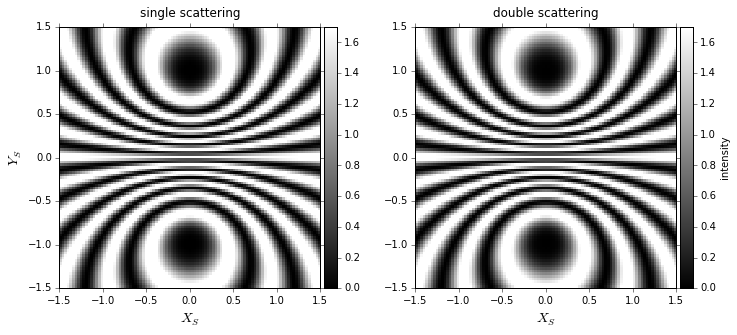


-----------------------------------------------------------------
total intensity SS: 10405.3  DS: 10193.2
min, max SS:  0.00100101658236 1.99900050483
min, max DS:  0.00101866416001 1.97694949522
-----------------------------------------------------------------
execution time:        0.15 min  (       8.99 sec)
simulation run results directory:  runs/dimer_55_incoherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\dimer_55_incoherent
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.005
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 34.55751918948772
incident wavelength in AA             : 0.18181818181818182
incident k-vector compon

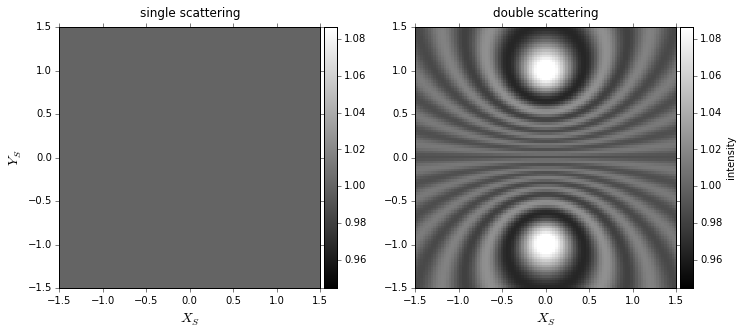


-----------------------------------------------------------------
total intensity SS: 10201  DS: 10211.3
min, max SS:  1.0 1.0
min, max DS:  0.965756055206 1.10781903803
-----------------------------------------------------------------
execution time:        0.15 min  (       9.21 sec)
simulation run results directory:  runs/dimer_50_coherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\dimer_50_coherent
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 1000.005
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 31.41592653589793
incident wavelength in AA             : 0.2
incident k-vector components x,y,z    : 0.0 0.0 31.41592653589793
in

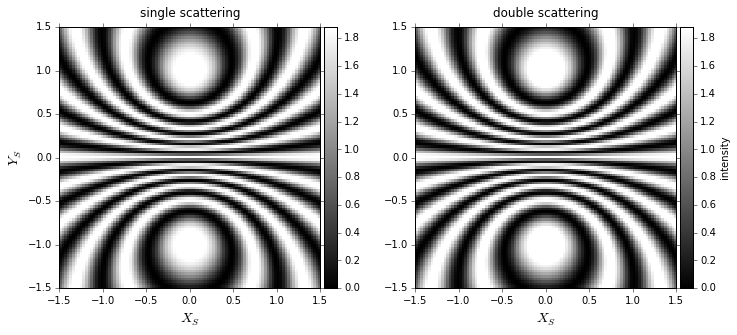


-----------------------------------------------------------------
total intensity SS: 10156.1  DS: 10421.9
min, max SS:  0.000999571114818 1.99900050483
min, max DS:  0.00101332433132 2.21101241331
-----------------------------------------------------------------
execution time:        0.15 min  (       9.26 sec)
simulation run results directory:  runs/dimer_50_incoherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\dimer_50_incoherent
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.005
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 31.41592653589793
incident wavelength in AA             : 0.2
incident k-vector components x,y,z    :

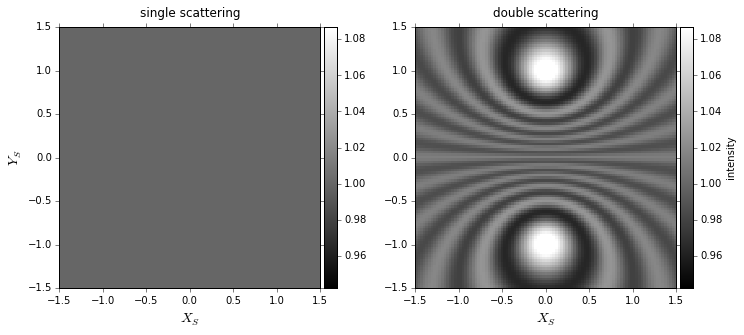


-----------------------------------------------------------------
total intensity SS: 10201  DS: 10215.9
min, max SS:  1.0 1.0
min, max DS:  0.963700914159 1.10837748281
-----------------------------------------------------------------
execution time:        0.15 min  (       9.09 sec)
simulation run results directory:  runs/dimer_525_coherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\dimer_525_coherent
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 1000.005
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 32.98672286269283
incident wavelength in AA             : 0.19047619047619047
incident k-vector components x,y,z    : 0.0 0.0 32

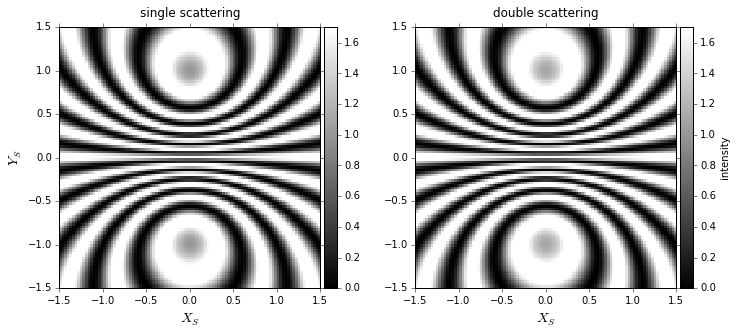


-----------------------------------------------------------------
total intensity SS: 10875.9  DS: 10889.3
min, max SS:  0.000999495171647 1.99900050483
min, max DS:  0.000999816173972 2.00102498967
-----------------------------------------------------------------
execution time:        0.15 min  (       9.07 sec)
simulation run results directory:  runs/dimer_525_incoherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\dimer_525_incoherent
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.005
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 32.98672286269283
incident wavelength in AA             : 0.19047619047619047
incident k-vector co

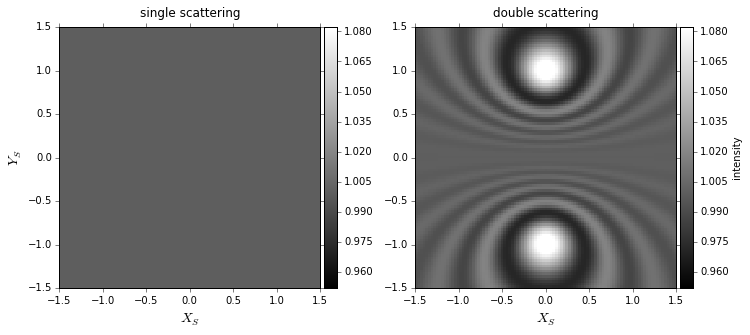


-----------------------------------------------------------------
total intensity SS: 10201  DS: 10214.3
min, max SS:  1.0 1.0
min, max DS:  0.971453852792 1.10156683848
-----------------------------------------------------------------
execution time:        0.15 min  (       8.83 sec)


In [18]:
DimerExample(DirName='dimer_55_coherent',InvWaveLength=5.5,theta=0,phi=0,CoherenceLength=1000.005)
DimerExample(DirName='dimer_55_incoherent',InvWaveLength=5.5,theta=0,phi=0,CoherenceLength=0.005)
DimerExample(DirName='dimer_50_coherent',InvWaveLength=5.0,theta=0,phi=0,CoherenceLength=1000.005)
DimerExample(DirName='dimer_50_incoherent',InvWaveLength=5.0,theta=0,phi=0,CoherenceLength=0.005)
DimerExample(DirName='dimer_525_coherent',InvWaveLength=5.25,theta=0,phi=0,CoherenceLength=1000.005)
DimerExample(DirName='dimer_525_incoherent',InvWaveLength=5.25,theta=0,phi=0,CoherenceLength=0.005)

simulation run results directory:  runs/dimer_tp_coherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\dimer_tp_coherent
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 1000.005
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 34.55751918948772
incident wavelength in AA             : 0.18181818181818182
incident k-vector components x,y,z    : 4.596917974170328 3.857272176678531 34.03251282267566
incident unit k-vector in AA^-1 x,y,z : [ 0.13302222  0.1116189   0.98480775]
Projection Type:  stereo
total pix:10201 current:10201 progress: 100.00% ->    0.0 min to go

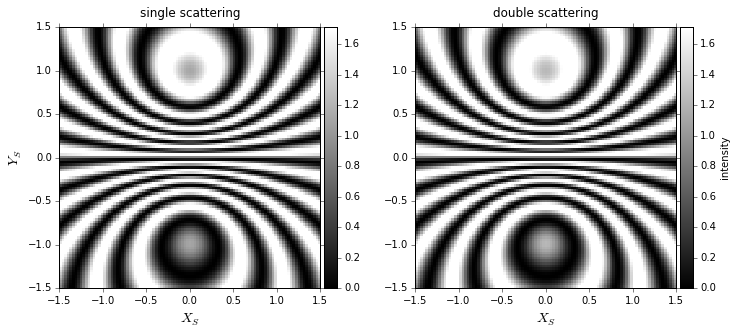


-----------------------------------------------------------------
total intensity SS: 10177.5  DS: 10213.4
min, max SS:  0.000999598310842 1.99900036106
min, max DS:  0.000998081733058 2.01234972011
-----------------------------------------------------------------
execution time:        0.15 min  (       9.17 sec)
simulation run results directory:  runs/dimer_tp_incoherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\dimer_tp_incoherent
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.005
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 34.55751918948772
incident wavelength in AA             : 0.18181818181818182
incident k-vector comp

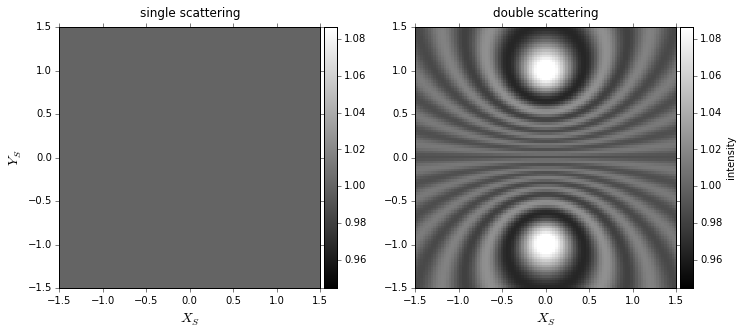


-----------------------------------------------------------------
total intensity SS: 10201  DS: 10211.3
min, max SS:  1.0 1.0
min, max DS:  0.965756055206 1.10781903803
-----------------------------------------------------------------
execution time:        0.15 min  (       9.23 sec)


In [19]:
DimerExample(DirName='dimer_tp_coherent',InvWaveLength=5.5,theta=10,phi=40,CoherenceLength=1000.005)
DimerExample(DirName='dimer_tp_incoherent',InvWaveLength=5.5,theta=10,phi=40,CoherenceLength=0.005)

In [20]:
def bccExample(DirName='bccExample',Energy=5000.0,theta=0.0,phi=0.0,
               CoherenceLength=0.5,RandomPhaseSize=0.0):
    global Gij, Kij
    global fScattWidth   
    global fScattStrength
    
    SaveData=True
    kwave = 0.5123*m.sqrt(Energy) # for electrons: 2Pi/lambda in 1/Angström for Energy in eV
    # matrix bounds for image
    kout_npix = 101 # x,y pixels in k-image
    #projection='kspace'
    projection='stereo'
    kscale=1.5
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale


    # scattering factor which approximates Kikuchi band scenario 
    fScattWidth=0.05   
    fScattStrength=0.1

    # optionally: set up directory for new results 
    if SaveData:
        os.chdir(BaseDir)
        gotoworkdir(DirName)
        print('base ipython notebook directory:', BaseDir)
        print('current working directory:', os.getcwd())

    # cluster structure setup
    # 2.8 = 9, 3.8=15, 11.8=531
    natoms,atoms,zs=make_cluster(rmax=3.8,FileName='bccUnitCellCluster.xyz')    
        
        
    t1 = time.time()
    irun=0
    
    Gij,Kij=calc_propagator_matrix(kwave,atoms)      
    aij=calc_coherence_matrix(atoms,CoherenceLength) 
    ISS,IDS,IntensitySS,IntensityDS=calc_leed(atoms,kwave,theta,phi,aij,kout_npix)
    if SaveData:
        np.savetxt('ss/INTEN_SS_'+str(irun+1).zfill(3)+'.dat',IntensitySS,fmt=' %.6e') 
        np.savetxt('ds/INTEN_DS_'+str(irun+1).zfill(3)+'.dat',IntensityDS,fmt=' %.6e')

    params = {"SystemTitle":None, 
              "Energy":Energy/1000, 
              "kwave":kwave,
              "theta":theta, 
              "phi":phi, 
              "nAtoms":natoms, 
              "CoherenceLength":CoherenceLength,
              "FilePrefix":DirName,
              "run":irun}

    plot_screen2(IntensitySS,IntensityDS,params,
                kxmin,kxmax,kymin,kymax,irun)#,FixVLim=1.08,FixVmin=0.95)
    
    ExperimentalImage = image.imread('../../fig/bcc15_stereo.png')
    params['FilePrefix']='Structure_'+DirName
    plot_structure(IntensityDS,ExperimentalImage,params,
                kxmin,kxmax,kymin,kymax,irun)#,FixVLim=1.08,FixVmin=0.95)
    print('')
    print('-----------------------------------------------------------------')
    print('total intensity SS: %g  DS: %g' % (ISS,IDS))
    print('min, max SS: ',np.min(IntensitySS),np.max(IntensitySS))
    print('min, max DS: ',np.min(IntensityDS),np.max(IntensityDS))
    print('-----------------------------------------------------------------')

    t2 = time.time()
    print ('execution time: %11.2f min  (%11.2f sec)' % ((t2-t1)/60.0,(t2-t1))    )
    if SaveData:
        os.chdir(BaseDir)

simulation run results directory:  runs/bcc15_coherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\bcc15_coherent
-----------------------------------------------------------------
creating atomic coordinates for cluster
-----------------------------------------------------------------
creating list of scatterers...
(make_cluster) number of atoms: 15
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 1000.0
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 36.225080400186826
incident wavelength in AA             : 0.17344848480024855
incident k-vector components x,y,z    : 0.0 0.0 36.225080400186826
incident unit k-vector in AA^-1 x,y,z : [ 

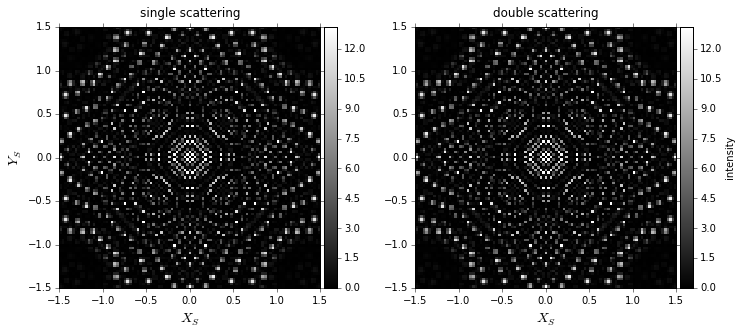

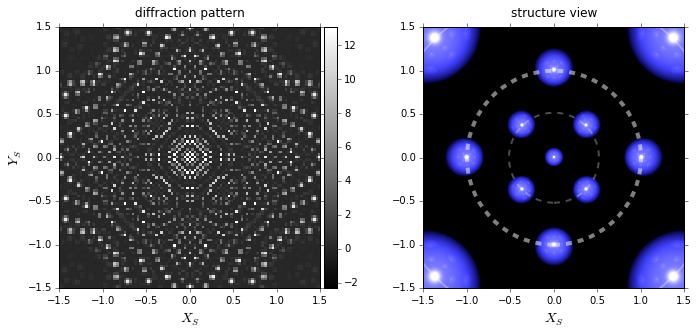


-----------------------------------------------------------------
total intensity SS: 10505.7  DS: 10499
min, max SS:  0.00213449601782 14.947155188
min, max DS:  0.00213972793706 15.3815503699
-----------------------------------------------------------------
execution time:        0.72 min  (      42.92 sec)


In [21]:
bccExample(DirName='bcc15_coherent',CoherenceLength=1000.0)

simulation run results directory:  runs/bcc15_incoherent_04
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\bcc15_incoherent_04
-----------------------------------------------------------------
creating atomic coordinates for cluster
-----------------------------------------------------------------
creating list of scatterers...
(make_cluster) number of atoms: 15
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.4
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 36.225080400186826
incident wavelength in AA             : 0.17344848480024855
incident k-vector components x,y,z    : 0.0 0.0 36.225080400186826
incident unit k-vector in AA^-1 x,y

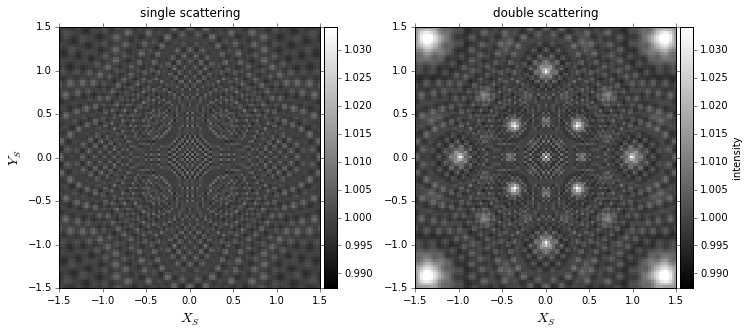

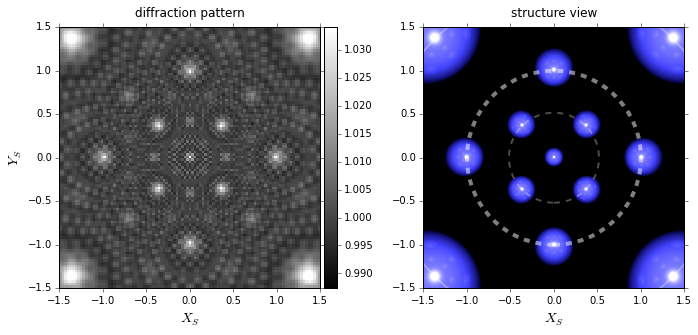


-----------------------------------------------------------------
total intensity SS: 10200.2  DS: 10216.9
min, max SS:  0.994984529069 1.0078662444
min, max DS:  0.994348200435 1.04107392609
-----------------------------------------------------------------
execution time:        0.72 min  (      43.06 sec)


In [22]:
bccExample(DirName='bcc15_incoherent_04',CoherenceLength=0.4)

simulation run results directory:  runs/bcc15_incoherent
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\bcc15_incoherent
-----------------------------------------------------------------
creating atomic coordinates for cluster
-----------------------------------------------------------------
creating list of scatterers...
(make_cluster) number of atoms: 15
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.0001
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 36.225080400186826
incident wavelength in AA             : 0.17344848480024855
incident k-vector components x,y,z    : 0.0 0.0 36.225080400186826
incident unit k-vector in AA^-1 x,y,z 

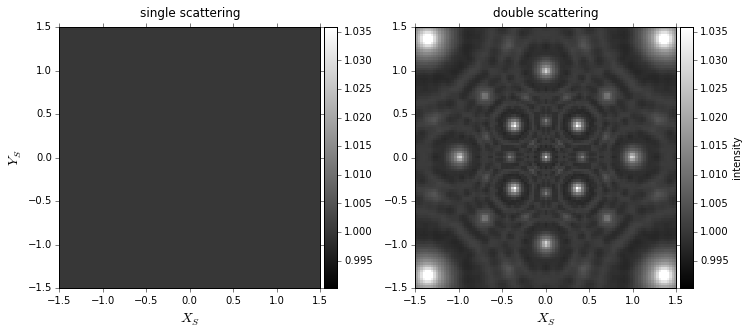

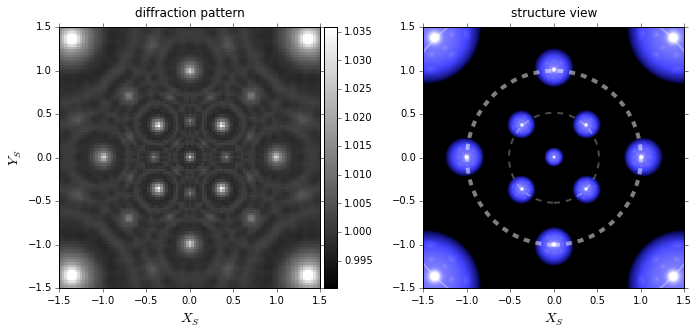


-----------------------------------------------------------------
total intensity SS: 10201  DS: 10217.7
min, max SS:  1.0 1.0
min, max DS:  0.997022325233 1.04262752745
-----------------------------------------------------------------
execution time:        0.73 min  (      43.72 sec)


In [23]:
bccExample(DirName='bcc15_incoherent',CoherenceLength=0.0001)

In [24]:
def ClusterExample(DirName='cluster',
                   npix=201,
                   Energy=5000.0,
                   theta=0.0,phi=0.0,
                   CoherenceLength=0.5,
                   RandomPhaseSize=0.0,
                   Imax=None,
                   Imin=None):
    
    global Gij, Kij
    global fScattWidth   
    global fScattStrength
    
    SaveData=True
    #RandomPhaseSize=0.0 # random phase in terms of 2Pi
    #Energy=5000.0
    kwave = 0.5123*m.sqrt(Energy) # for electrons: 2Pi/lambda in 1/Angström for Energy in eV
    #theta = 0.0      # polar incident angle in Degrees, 180=transmission
    #phi = 0.0        # azimuthal incident angle
    
    #kwave=float(10.5*2.0*m.pi) #DIMER

    # matrix bounds for image
    kout_npix = npix # x,y pixels in k-image
    #projection='kspace'
    projection='stereo'
    kscale=1.5
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale

    # cluster structure setup
    ClusterRadius=8 # 7=113 15=1067
    natoms,atoms,zs=make_cluster(rmax=ClusterRadius)

    # scattering factor which approximates Kikuchi band scenario 
    #fScattWidth=0.05   
    #fScattStrength=0.1
    fScattWidth=0.05   
    fScattStrength=0.1

    # optionally: set up directory for new results 
    if SaveData:
        os.chdir(BaseDir)
        gotoworkdir(DirName)
        print('base ipython notebook directory:', BaseDir)
        print('current working directory:', os.getcwd())

    t1 = time.time()
    irun=0
    
    Gij,Kij=calc_propagator_matrix(kwave,atoms)      
    aij=calc_coherence_matrix(atoms,CoherenceLength) 
    ISS,IDS,IntensitySS,IntensityDS=calc_leed(atoms,kwave,theta,phi,aij,
                                              kout_npix,RandomPhaseFactor=RandomPhaseSize)
    if SaveData:
        np.savetxt('ss/INTEN_SS_'+str(irun).zfill(3)+'.dat',IntensitySS,fmt=' %.6e') 
        np.savetxt('ds/INTEN_DS_'+str(irun).zfill(3)+'.dat',IntensityDS,fmt=' %.6e')

    params = {"SystemTitle":None, 
              "Energy":Energy/1000, 
              "kwave":kwave,
              "theta":theta, 
              "phi":phi, 
              "nAtoms":natoms, 
              "CoherenceLength":CoherenceLength,
              "FilePrefix":DirName,
              "ClusterRadius":ClusterRadius,
              "run":irun}
    
    
    plot_screen2(IntensitySS,IntensityDS,params,
                kxmin,kxmax,kymin,kymax,irun,FixVLim=Imax,FixVmin=Imin)
    
    ExperimentalImage = image.imread('../../fig/bcc_stereo.png')
    params['FilePrefix']='Structure_'+DirName
    plot_structure(IntensityDS,ExperimentalImage,params,
                kxmin,kxmax,kymin,kymax,irun,FixVLim=Imax,FixVmin=Imin)
    
    print('')
    print('-----------------------------------------------------------------')
    print('total intensity SS: %g  DS: %g' % (ISS,IDS))
    print('min, max SS: ',np.min(IntensitySS),np.max(IntensitySS))
    print('min, max DS: ',np.min(IntensityDS),np.max(IntensityDS))
    print('-----------------------------------------------------------------')

    t2 = time.time()
    print ('execution time: %11.2f min  (%11.2f sec)' % ((t2-t1)/60.0,(t2-t1))    )
    if SaveData:
        os.chdir(BaseDir)

-----------------------------------------------------------------
creating atomic coordinates for cluster
-----------------------------------------------------------------
creating list of scatterers...
(make_cluster) number of atoms: 169
simulation run results directory:  runs/cluster_169_coh01
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\cluster_169_coh01
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.1
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 36.225080400186826
incident wavelength in AA             : 0.17344848480024855
incident k-vector components x,y,z    : 0.0 0.0 36.225080400186826
incident unit k-vector in AA^-1 x,y,z 

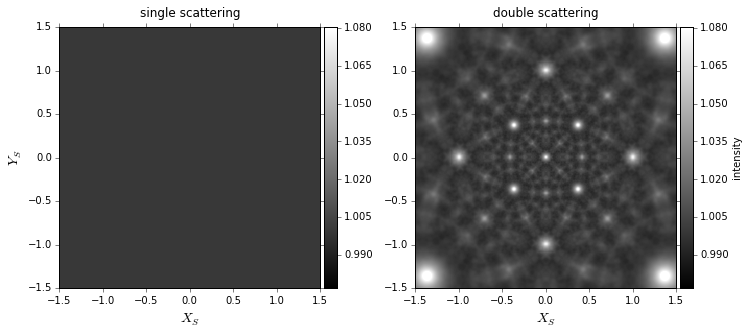

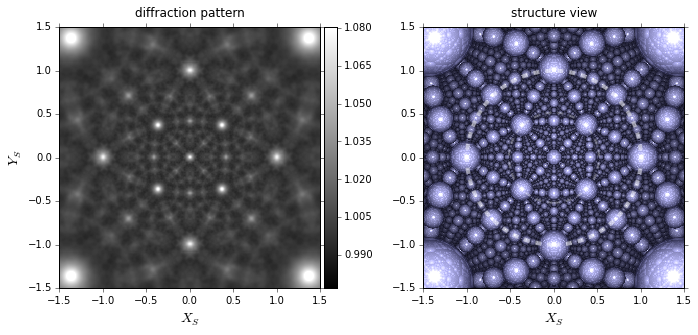


-----------------------------------------------------------------
total intensity SS: 63001  DS: 63294.3
min, max SS:  0.999999999968 1.00000000003
min, max DS:  0.992412103964 1.0956854972
-----------------------------------------------------------------
execution time:       57.21 min  (    3432.85 sec)


In [25]:
ClusterExample(DirName='cluster_169_coh01',CoherenceLength=0.1,npix=251)

-----------------------------------------------------------------
creating atomic coordinates for cluster
-----------------------------------------------------------------
creating list of scatterers...
(make_cluster) number of atoms: 169
simulation run results directory:  runs/cluster_169_coh04
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\cluster_169_coh04
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.4
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 36.225080400186826
incident wavelength in AA             : 0.17344848480024855
incident k-vector components x,y,z    : 0.0 0.0 36.225080400186826
incident unit k-vector in AA^-1 x,y,z 

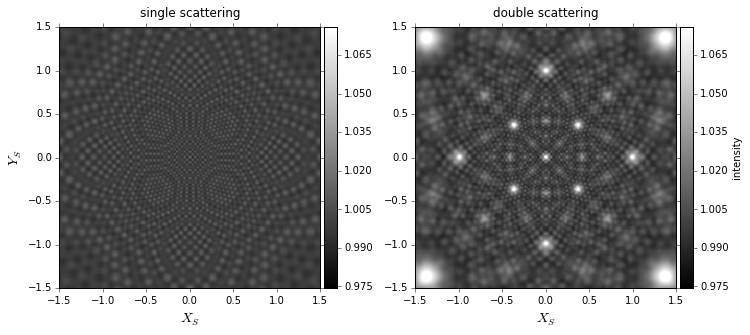

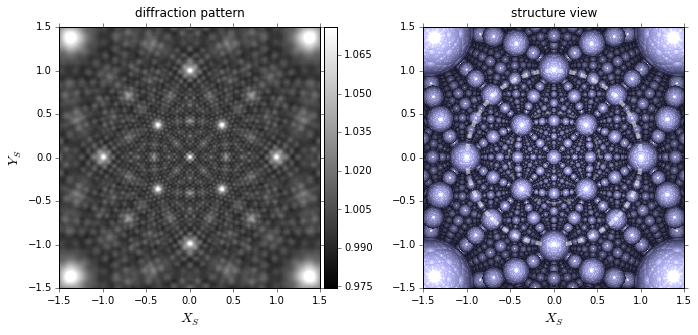


-----------------------------------------------------------------
total intensity SS: 62993.4  DS: 63286.3
min, max SS:  0.993181331406 1.01212280524
min, max DS:  0.989548233346 1.09109641615
-----------------------------------------------------------------
execution time:       55.56 min  (    3333.77 sec)


In [26]:
ClusterExample(DirName='cluster_169_coh04',CoherenceLength=0.4,npix=251)

-----------------------------------------------------------------
creating atomic coordinates for cluster
-----------------------------------------------------------------
creating list of scatterers...
(make_cluster) number of atoms: 169
simulation run results directory:  runs/cluster_169_coh1000
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\cluster_169_coh1000
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 1000.0
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 36.225080400186826
incident wavelength in AA             : 0.17344848480024855
incident k-vector components x,y,z    : 0.0 0.0 36.225080400186826
incident unit k-vector in AA^-1

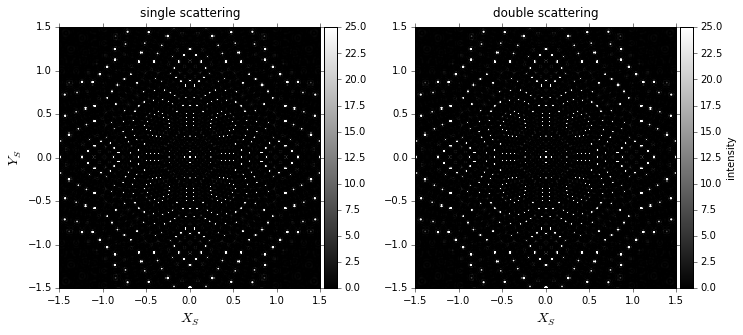

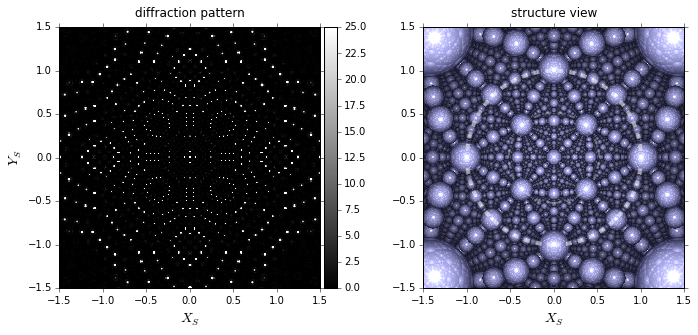


-----------------------------------------------------------------
total intensity SS: 61082.4  DS: 60985.4
min, max SS:  0.00147642921225 167.594411969
min, max DS:  0.0014801654831 180.155973597
-----------------------------------------------------------------
execution time:       56.13 min  (    3367.66 sec)


In [27]:
ClusterExample(DirName='cluster_169_coh1000',CoherenceLength=1000.0,npix=251,Imax=25,Imin=0)

-----------------------------------------------------------------
creating atomic coordinates for cluster
-----------------------------------------------------------------
creating list of scatterers...
(make_cluster) number of atoms: 169
simulation run results directory:  runs/cluster_169_random1
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\cluster_169_random1
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.1
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 36.225080400186826
incident wavelength in AA             : 0.17344848480024855
incident k-vector components x,y,z    : 0.0 0.0 36.225080400186826
incident unit k-vector in AA^-1 x,

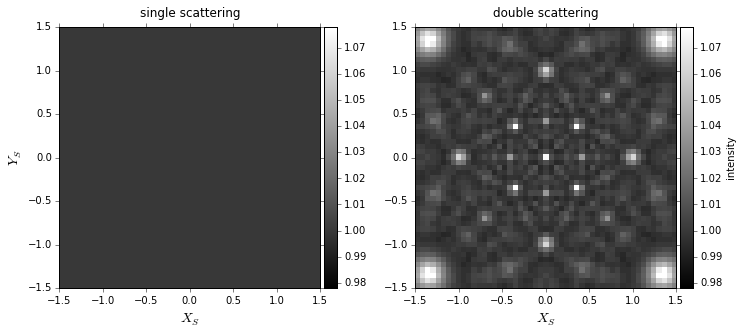

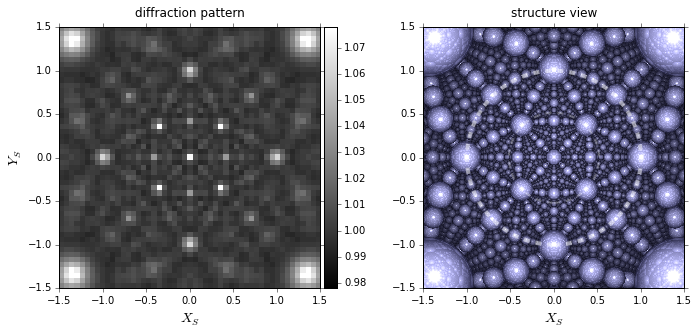


-----------------------------------------------------------------
total intensity SS: 2601  DS: 2613.48
min, max SS:  0.999999999968 1.00000000003
min, max DS:  0.992953375648 1.09274747418
-----------------------------------------------------------------
execution time:        2.64 min  (     158.29 sec)


In [28]:
ClusterExample(DirName='cluster_169_random1',
               CoherenceLength=0.1,npix=51,
               RandomPhaseSize=1.0)

In [29]:
def Experiment(DirName='experiment',
                   npix=101,
                   Energy=20000.0,
                   theta=0.0,phi=0.0,
                   CoherenceLength=0.001,
                   RandomPhaseSize=0.0,
                   ClusterRadius=9 ):
    global Gij, Kij
    global fScattWidth   
    global fScattStrength
    
    SaveData=True
    kwave = 0.5123*m.sqrt(Energy) # for electrons: 2Pi/lambda in 1/Angström for Energy in eV
    
    # matrix bounds for image
    kout_npix = npix # x,y pixels in k-image
    #projection='kspace'
    projection='gnomonic'
    #kxmin,kxmax,kymin,kymax=getGnomonicLimits()
    kscale=1.5
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale
    # cluster structure setup
    # 7=113 9=257 15=1067
    natoms,atoms,zs=make_cluster(rmax=ClusterRadius,
                                 phi1=328.83*m.pi/180.0,
                                 PHI=47.95*m.pi/180.0,
                                 phi2=38.45*m.pi/180.0)

    # scattering factor which approximates Kikuchi band scenario 
    #fScattWidth=0.05   
    #fScattStrength=0.1
    fScattWidth=0.05   
    fScattStrength=0.1

    # optionally: set up directory for new results 
    if SaveData:
        os.chdir(BaseDir)
        gotoworkdir(DirName)
        print('base ipython notebook directory:', BaseDir)
        print('current working directory:', os.getcwd())

    t1 = time.time()
    irun=0
    
    Gij,Kij=calc_propagator_matrix(kwave,atoms)      
    aij=calc_coherence_matrix(atoms,CoherenceLength) 
    ISS,IDS,IntensitySS,IntensityDS=calc_leed(atoms,kwave,theta,phi,aij,
                                              kout_npix,
                                              RandomPhaseFactor=RandomPhaseSize,
                                              Projection=projection)
    if SaveData:
        np.savetxt('ss/INTEN_SS_'+str(irun).zfill(3)+'.dat',IntensitySS,fmt=' %.6e') 
        np.savetxt('ds/INTEN_DS_'+str(irun).zfill(3)+'.dat',IntensityDS,fmt=' %.6e')

    params = {"SystemTitle":None, 
              "Energy":Energy/1000, 
              "kwave":kwave,
              "theta":theta, 
              "phi":phi, 
              "nAtoms":natoms, 
              "CoherenceLength":CoherenceLength,
              "FilePrefix":DirName,
              "ClusterRadius":ClusterRadius,
              "run":irun}

    plot_screen2(IntensitySS,np.rot90(IntensityDS),params,
                kxmin,kxmax,kymin,kymax,irun,FixVLim=1.03,FixVmin=0.995)
    
    #ExperimentalImage = image.imread('py/bcc_stereo.png')
    #params['FilePrefix']='Structure_'+DirName
    #plot_structure(IntensityDS,ExperimentalImage,params,
    #            kxmin,kxmax,kymin,kymax,irun)#,FixVLim=1.3,FixVmin=0.7)
    
    print('')
    print('-----------------------------------------------------------------')
    print('total intensity SS: %g  DS: %g' % (ISS,IDS))
    print('-----------------------------------------------------------------')

    t2 = time.time()
    print ('execution time: %11.2f min  (%11.2f sec)' % ((t2-t1)/60.0,(t2-t1))    )
    if SaveData:
        os.chdir(BaseDir)
        
    return IntensityDS

def plotExperiment(Image,kscale=1.5,FileName='W20kVExp',
                   plotExp=False,alphaExp=0.4,
                   MaxValue=1.03, MinValue=0.992):
    
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale   
        
    plt.figure(figsize=(5,5), dpi=300)
    #plt.subplots_adjust(wspace=0.15,top=0.85,left=0.08,hspace=0.05,right=0.92)    
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    extent = [kxmin,kxmax,kymin,kymax] 
    #colormap=cm.gray_r # or cm.spectral
    colormap=cm.gray
    #colormap=cm.spectral
    
    plt.imshow(Image, extent=extent, interpolation='nearest',
               cmap=colormap,vmax=MaxValue,vmin=MinValue,zorder=-1) 

    if plotExp:
        ExperimentalImage = image.imread('fig/W_20kV.png')
        ekxmin,ekxmax,ekymin,ekymax=getGnomonicLimits()
        extent = [ekxmin,ekxmax,ekymin,ekymax] 
        plt.imshow(ExperimentalImage, extent=extent, 
                   interpolation='nearest',cmap=colormap,alpha=alphaExp) 

    
    #plt.title('diffraction pattern',fontsize=12,y=1.02)
    plt.xlim(kxmin,kxmax)    # y-axis of sample
    plt.ylim(kymin,kymax)   # z-axis of sample
    plt.xlabel(r"$X_G$",fontsize=14,labelpad=5) # labelpad is offset
    plt.ylabel(r"$Y_G$",fontsize=14,labelpad=5)
    

    
    #set color bar to same height as plot
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb=plt.colorbar(cax=cax)
    #cb.set_label('intensity')
    

    # Hemisphere Circle    
    #circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*90.0)),
    #                   alpha=0.5,edgecolor='w',facecolor='None',
    #                   linewidth=4, linestyle='dashed')
    #plt.gcf().gca().add_artist(circle1)   
    #circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*54.7)),
    #                   alpha=0.3,edgecolor='w',facecolor='None',
    #                   linewidth=2, linestyle='dashed')
    #plt.gcf().gca().add_artist(circle1)   
    #circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*(180.0-54.7))),
    #                   alpha=0.3,edgecolor='w',facecolor='None',linewidth=2)
    #plt.gcf().gca().add_artist(circle1)        

    plt.savefig(FileName+'.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(FileName+'.png', dpi=300, bbox_inches='tight')
        
        

In [30]:
ImageMatrix=Experiment(npix=501,ClusterRadius=9)

-----------------------------------------------------------------
creating atomic coordinates for cluster
-----------------------------------------------------------------
creating list of scatterers...
(make_cluster) number of atoms: 257
simulation run results directory:  runs/experiment
base ipython notebook directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src
current working directory: F:\OneDrive\Work\mypapers\current_papers\AJP-KLINES\twice\src\runs\experiment
Calculation of propagator structure matrix...
Calculation of coherence matrix...
Coherence Length: 0.001
-----------------------------------------------------------------
Cluster Double Scattering Simulation
-----------------------------------------------------------------
incident k-vector magnitude           : 72.45016080037365
incident wavelength in AA             : 0.08672424240012427
incident k-vector components x,y,z    : 0.0 0.0 72.45016080037365
incident unit k-vector in AA^-1 x,y,z : [ 0.  0.  1.

KeyboardInterrupt: 

In [ ]:
Wgnom = image.imread('fig/bcc_Wexp.bmp')
plotExperiment(np.rot90(ImageMatrix),plotExp=False,FileName="fig/W20kVCluster")
plotExperiment(np.rot90(ImageMatrix),plotExp=True,FileName="fig/W20kVClusterExp",alphaExp=0.35)
plotExperiment(np.flipud(Wgnom),plotExp=True,FileName="fig/W20kVStruExp",alphaExp=0.6)

In [ ]:
IntensityDimer =  np.loadtxt('fig/INTEN_DS_DIMER.dat')
IntensityNeutron =  np.loadtxt('fig/INTEN_DS_NEUTRON.dat')
plotExperiment(IntensityDimer,plotExp=False,FileName="fig/fDimer",MaxValue=1.1, MinValue=0.95)
plotExperiment(IntensityNeutron,plotExp=False,FileName="fig/fNeutron",MaxValue=1.4, MinValue=0.6)

### Animation: Coherence Length 

In [ ]:
def ClusterExample113Ani(DirName='Cluster113Ani',Energy=5000.0,
                         theta=0.0,phi=0.0,CoherenceLength=0.5,
                         RandomPhaseSize=0.0,nsteps=10):
    global Gij, Kij
    global fScattWidth   
    global fScattStrength
    
    SaveData=True
    kwave = 0.5123*m.sqrt(Energy) # for electrons: 2Pi/lambda in 1/Angström for Energy in eV
    #theta = polar incident angle in Degrees, 180=transmission
    #phi = azimuthal incident angle

    # matrix bounds for image
    kout_npix = 201 # x,y pixels in k-image
    projection='stereo' # or 'kspace'
    kscale=1.5
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale

    # cluster structure setup
    ClusterRadius=7
    natoms,atoms,zs=make_cluster(rmax=ClusterRadius)

    # scattering factor which approximates Kikuchi band scenario 
    fScattWidth=0.05   
    fScattStrength=0.1

    # optionally: set up directory for new results 
    if SaveData:
        os.chdir(BaseDir)
        gotoworkdir(DirName)
        print('base ipython notebook directory:', BaseDir)
        print('current working directory:', os.getcwd())

    t1 = time.time()
    # generic loop parameters P0,P1,dP
    nruns=nsteps+1
    P0=0.2 # short coherence length, Kikuchi-like
    P1=6.0 # long coherence length ->spots
    factor=(P1/P0)**(1.0/float(nruns))


    t1 = time.time()
    for irun in range(nruns+1):
        LoopParam=P0*(factor**irun) # generic loop parameter
        CoherenceLength=LoopParam # electron kinetic energy in eV

        Gij,Kij=calc_propagator_matrix(kwave,atoms)      
        aij=calc_coherence_matrix(atoms,CoherenceLength) 
        ISS,IDS,IntensitySS,IntensityDS=calc_leed(atoms,kwave,theta,phi,aij,kout_npix)
        if SaveData:
            np.savetxt('ss/INTEN_SS_'+str(irun+1).zfill(3)+'.dat',IntensitySS,fmt=' %.6e') 
            np.savetxt('ds/INTEN_DS_'+str(irun+1).zfill(3)+'.dat',IntensityDS,fmt=' %.6e')

        params = {"SystemTitle":r"113 atoms $a_{bcc}=3\AA$    $\lambda=0.17\AA$  $f_{DS}(0)$=0.1   L$_c$=%8.3f $\AA$" % CoherenceLength, 
                  "Energy":Energy/1000, 
                  "kwave":kwave,
                  "theta":theta, 
                  "phi":phi, 
                  "nAtoms":natoms, 
                  "CoherenceLength":CoherenceLength,
                  "FilePrefix":DirName,
                  "ClusterRadius":ClusterRadius,
                  "run":irun}

        plot_screen2(IntensitySS,IntensityDS,params,
                    kxmin,kxmax,kymin,kymax,irun,Animation=True)#,FixVLim=1.3,FixVmin=0.7)
        print('')
        print('-----------------------------------------------------------------')
        print('total intensity SS: %g  DS: %g' % (ISS,IDS))
        print('SS min max : %g  %g' % (np.min(IntensitySS),np.max(IntensitySS)) )
        print('DS min max : %g  %g' % (np.min(IntensityDS),np.max(IntensityDS)) )
        print('-----------------------------------------------------------------')

    t2 = time.time()
    print ('execution time: %11.2f min  (%11.2f sec)' % ((t2-t1)/60.0,(t2-t1))    )
    if SaveData:
        os.chdir(BaseDir)

In [ ]:
ClusterExample113Ani(DirName='Cluster113Ani', nsteps=5)


### Animation: explicit random phases

In [ ]:
def ClusterExampleRandomAni(DirName='ClusterRandomAni',Energy=5000.0,
                         theta=0.0,phi=0.0,CoherenceLength=1000.0,
                         RandomPhaseSize=1.0,ntrials=10):
    global Gij, Kij
    global fScattWidth   
    global fScattStrength
    
    SaveData=True
    kwave = 0.5123*m.sqrt(Energy) # for electrons: 2Pi/lambda in 1/Angström for Energy in eV

    # matrix bounds for image
    kout_npix = 501 # x,y pixels in k-image
    #projection='kspace'
    projection='stereo'
    kscale=1.5
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale

    # cluster structure setup
    ClusterRadius=6.8
    natoms,atoms,zs=make_cluster(rmax=ClusterRadius)
    # test cluster 4 atoms
    #natoms=4
    #atoms=np.array([[1.0, 0.0, 0.0],
    #                [0.0, 0.0, 0.0],
    #                [0.0, 1.0, 0.0],
    #                [0.0, 0.0, 1.0]])
    #zs=np.array([[26],[26],[26],[26]])
    
    # scattering factor which approximates Kikuchi band scenario 
    fScattWidth=0.05   
    #fScattWidth=0.002 #dimer
    fScattStrength=0.5
    
    # optionally: set up directory for new results 
    if SaveData:
        os.chdir(BaseDir)
        gotoworkdir(DirName)
        print('base ipython notebook directory:', BaseDir)
        print('current working directory:', os.getcwd())
    
    # the summed intensities
    IntensitySSSum=np.zeros((kout_npix,kout_npix), dtype=np.float)
    IntensityDSSum=np.zeros((kout_npix,kout_npix), dtype=np.float)

    nstart=1
    nend=ntrials
    nruns=0
    t1 = time.time()
    Gij,Kij=calc_propagator_matrix(kwave,atoms)
    for irun in range(nstart,nend+1):
        nruns+=1 # number of random trial
        aij=calc_coherence_matrix(atoms,CoherenceLength,randomFactor=RandomPhaseSize) 

        ISS,IDS,IntensitySS,IntensityDS=calc_leed(atoms,kwave,
                  theta,phi,aij,kout_npix, RandomPhaseFactor=0.0)
        IntensitySSSum += IntensitySS
        IntensityDSSum += IntensityDS

        if SaveData:
            np.savetxt('ss/INTEN_SS_'+str(irun).zfill(5)+'.dat',IntensitySS,fmt=' %.6e') 
            np.savetxt('ds/INTEN_DS_'+str(irun).zfill(5)+'.dat',IntensityDS,fmt=' %.6e')
            np.savetxt('ss/INTEN_SS_AVE_'+str(irun).zfill(5)+'.dat',IntensitySSSum/nruns,fmt=' %.6e') 
            np.savetxt('ds/INTEN_DS_AVE_'+str(irun).zfill(5)+'.dat',IntensityDSSum/nruns,fmt=' %.6e')  
 
        params = {"SystemTitle":None, #r"113 atoms  bcc  a=3$\AA$  L$_c$=%8.3f $\AA$" % CoherenceLength, 
                  "Energy":Energy/1000, 
                  "kwave":kwave,
                  "theta":theta, 
                  "phi":phi, 
                  "nAtoms":natoms, 
                  "CoherenceLength":CoherenceLength,
                  "FilePrefix":DirName+'_RAND',
                  "ClusterRadius":ClusterRadius,
                  "run":irun}
        # current random result 
        plot_screen2(IntensitySS,IntensityDS, params,
                     kxmin,kxmax,kymin,kymax,irun,
                     Animation=True, FixVLim=4.0,FixVmin=0.0,
                     dpi=600)
        # averaged result so far
        params['FilePrefix']=DirName
        plot_screen2(IntensitySSSum/nruns,IntensityDSSum/nruns, params,
                     kxmin,kxmax,kymin,kymax,irun,
                     Animation=True,dpi=600)#,FixVLim=2.0,FixVmin=0.0)


        
        print('')
        print('-----------------------------------------------------------------')
        print('total intensity SS: %g  DS: %g' % (ISS,IDS))
        print('min SS:'+str(np.min(IntensitySS)))
        print('min DS:'+str(np.min(IntensityDS)))
        print('-----------------------------------------------------------------')

        
    t2 = time.time()
    print ('execution time: %11.2f min  (%11.2f sec)' % ((t2-t1)/60.0,(t2-t1))    )
    if SaveData:
        os.chdir(BaseDir)

In [ ]:
ClusterExampleRandomAni(DirName='ClusterRandomAniExample',ntrials=5)


In [ ]:
# dimer with 5000eV to show difference of r-change vs. phase change at constant positions
def DimerExampleRandomPos(DirName='ClusterRandomPos',Energy=5000.0,
                         theta=180.0,phi=0.0,CoherenceLength=1000.01,
                         RandomPhaseSize=0.0):
    global Gij, Kij
    global fScattWidth   
    global fScattStrength
    
    SaveData=True
    kwave = 0.5123*m.sqrt(Energy) # for electrons: 2Pi/lambda in 1/Angström for Energy in eV
    wavelength= 2.0*m.pi/kwave # in angström

    # matrix bounds for image
    kout_npix = 251 # x,y pixels in k-image
    #projection='kspace'
    projection='stereo'
    kscale=1.5
    kxmin=-kscale
    kxmax=+kscale
    kymin=-kscale
    kymax=+kscale

    
    # scattering factor which approximates Kikuchi band scenario 
    #fScattWidth=0.05   
    fScattWidth=0.005 #dimer
    fScattStrength=0.5
    
    # optionally: set up directory for new results 
    if SaveData:
        os.chdir(BaseDir)
        gotoworkdir(DirName)
        print('base ipython notebook directory:', BaseDir)
        print('current working directory:', os.getcwd())
    
    # the summed intensities
    IntensitySSSum=np.zeros((kout_npix,kout_npix), dtype=np.float)
    IntensityDSSum=np.zeros((kout_npix,kout_npix), dtype=np.float)

    nstart=1
    nend=1000
    nruns=0
    t1 = time.time()

    for irun in range(nstart,nend+1):
        nruns+=1 # number of random trial
        
        # dimer atoms, random position
        ClusterRadius=1
        natoms=2
        dr=1.4*wavelength
        xrandom=3.0 + dr*(-1.0+2.0*np.random.random())# x vertical 
        yrandom=0.0 + dr*(-1.0+2.0*np.random.random()) # y is horizontal
        zrandom=0.0 + dr*(-1.0+2.0*np.random.random()) 
        atoms=np.array([[0.0, 0.0, 0.0],
                        [xrandom, yrandom, zrandom]])
        zs=np.array([[26],[26]])
   
        Gij,Kij=calc_propagator_matrix(kwave,atoms)
        aij=calc_coherence_matrix(atoms,CoherenceLength,randomFactor=RandomPhaseSize) 

        ISS,IDS,IntensitySS,IntensityDS=calc_leed(atoms,kwave,
                  theta,phi,aij,kout_npix, RandomPhaseFactor=0.0)
        IntensitySSSum += IntensitySS
        IntensityDSSum += IntensityDS

        if SaveData:
            np.savetxt('ss/INTEN_SS_'+str(irun).zfill(5)+'.dat',IntensitySS,fmt=' %.6e') 
            np.savetxt('ds/INTEN_DS_'+str(irun).zfill(5)+'.dat',IntensityDS,fmt=' %.6e')
            np.savetxt('ss/INTEN_SS_AVE_'+str(irun).zfill(5)+'.dat',IntensitySSSum/float(nruns),fmt=' %.6e') 
            np.savetxt('ds/INTEN_DS_AVE_'+str(irun).zfill(5)+'.dat',IntensityDSSum/float(nruns),fmt=' %.6e')  
 
        params = {"SystemTitle":None, #r"113 atoms  bcc  a=3$\AA$  L$_c$=%8.3f $\AA$" % CoherenceLength, 
                  "Energy":Energy/1000, 
                  "kwave":kwave,
                  "theta":theta, 
                  "phi":phi, 
                  "nAtoms":natoms, 
                  "CoherenceLength":CoherenceLength,
                  "FilePrefix":DirName+'_RAND',
                  "ClusterRadius":ClusterRadius,
                  "run":irun}
        # current random result 
        plot_screen2(IntensitySS,IntensityDS, params,
                     kxmin,kxmax,kymin,kymax,irun,
                     Animation=True, FixVLim=2.0,FixVmin=0.0,
                     dpi=150)
        # averaged result so far
        params['FilePrefix']=DirName
        plot_screen2(IntensitySSSum/float(nruns),IntensityDSSum/float(nruns), params,
                     kxmin,kxmax,kymin,kymax,irun,
                     Animation=True,dpi=150,FixVLim=1.4,FixVmin=0.6)


        
        print('')
        print('-----------------------------------------------------------------')
        print('total intensity SS: %g  DS: %g' % (ISS,IDS))
        print('min SS:'+str(np.min(IntensitySS)))
        print('min DS:'+str(np.min(IntensityDS)))
        print('-----------------------------------------------------------------')

        
    t2 = time.time()
    print ('execution time: %11.2f min  (%11.2f sec)' % ((t2-t1)/60.0,(t2-t1))    )
    if SaveData:
        os.chdir(BaseDir)

In [ ]:
DimerExampleRandomPos()

### Replotting of Data

In [ ]:
# replotting existing data
os.chdir(BaseDir)
RunDir='runs/bcc15_incoherent'
os.chdir(RunDir)
ssfile='ss/INTEN_SS_002.dat'
dsfile='ds/INTEN_DS_002.dat'
ExperimentalImage = image.imread('fig/bcc15_stereo.png')
IntensitySS =  np.loadtxt(ssfile) 
IntensityDS =  np.loadtxt(dsfile)

# matrix bounds for image
kout_npix = 101 # x,y pixels in k-image
#projection='kspace'
projection='stereo'
kscale=1.5
kxmin=-kscale
kxmax=+kscale
kymin=-kscale
kymax=+kscale
irun=1
params = {"SystemTitle":None, 
          "FilePrefix":'Replot',
          "run":irun}

plot_screen2(IntensitySS,IntensityDS,params,
            kxmin,kxmax,kymin,kymax,irun,FixVLim=0.1,FixVmin=0)


params['FilePrefix']='Re_Structure_'
plot_structure(IntensityDS,ExperimentalImage,params,
            kxmin,kxmax,kymin,kymax,irun,FixVLim=0.1,FixVmin=0)
    

In [ ]:
# averaging and plotting of MC runs
os.chdir(BaseDir)
#directory with ascii matrices under /ds
RunDir='F:/TEMP/runs/ClusterRandomAni'
os.chdir(RunDir)

ntotal=0

# 3rd batch
nstart=1
nend=500
for irun in range(nstart,nend+1):     
    ntotal+=1
    ssfile=RunDir+'/ds/INTEN_SS_'+str(irun).zfill(5)+'.dat'
    dsfile=RunDir+'/ds/INTEN_DS_'+str(irun).zfill(5)+'.dat'
    currentSS =  np.loadtxt(ssfile) 
    currentDS =  np.loadtxt(dsfile)
    #print(ssfile)
    #print(dsfile)
    if (ntotal==1):
        IntensitySS =  currentSS 
        IntensityDS =  currentDS
    else:
        IntensitySS += currentSS 
        IntensityDS += currentDS            

        
# 4th batch
nstart=501
nend=1000
for irun in range(nstart,nend+1):     
    ntotal+=1
    ssfile=RunDir+'/ds/INTEN_SS_'+str(irun).zfill(5)+'.dat'
    dsfile=RunDir+'/ds/INTEN_DS_'+str(irun).zfill(5)+'.dat'
    currentSS =  np.loadtxt(ssfile) 
    currentDS =  np.loadtxt(dsfile)
    #print(ssfile)
    #print(dsfile)
    if (ntotal==1):
        IntensitySS =  currentSS 
        IntensityDS =  currentDS
    else:
        IntensitySS += currentSS 
        IntensityDS += currentDS              
        

# average of all
print(ntotal)
IntensitySS /= float(ntotal) 
IntensityDS /= float(ntotal)     

In [ ]:
# matrix bounds for image
kout_npix = 301 # x,y pixels in k-image
#projection='kspace'
projection='stereo'
kscale=1.5
kxmin=-kscale
kxmax=+kscale
kymin=-kscale
kymax=+kscale
irun=1
params = {"SystemTitle":None, 
          "FilePrefix":'Replot',
          "run":irun}

plot_screen2(IntensitySS,IntensityDS,params,
            kxmin,kxmax,kymin,kymax,0,FixVLim=0.85,FixVmin=1.28)

The dependence of both types of diffraction paterns is characteristically different.

In [ ]:
def plot_stereo():
    """
    makes stereographic figure
    """
    # Matplotlib option: set ticks outside of axis in plot
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    #mpl.rcParams['figure.figsize'] = 11,5  
    
    #plt.figure()
    plt.figure(figsize=(5,5), dpi=600)
    plt.subplots_adjust(wspace=0.15,top=0.85,left=0.08,hspace=0.05,right=0.92)    
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    extent = [-1.5,1.5,-1.5,1.5] 
    #colormap=cm.gray_r # or cm.spectral
    colormap=cm.gray
    #colormap=cm.spectral
    #plt.imshow(Idiff, extent=extent, interpolation='nearest',cmap=cm.spectral)
    ImageMatrix1 = image.imread('c:/temp/bcc15.png')
    plt.imshow(ImageMatrix1, extent=extent, interpolation='nearest') 
    plt.title('stereographic projection',fontsize=12,y=1.02)
    plt.xlim(-1.5,1.5)    # y-axis of sample
    plt.ylim(-1.5,1.5)   # z-axis of sample
    plt.xlabel(r"$X_S$",fontsize=14,labelpad=5) # labelpad is offset
    plt.ylabel(r"$Y_S$",fontsize=14,labelpad=5)
    #for ThetaGnom in range(0,141,10):       
    #    circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*ThetaGnom)),
    #                   alpha=1.0,edgecolor='w',facecolor='None',linewidth=1)
    #    plt.gcf().gca().add_artist(circle1)  
    # Hemisphere Circle    
    circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*90.0)),
                       alpha=0.5,edgecolor='w',facecolor='None',
                       linewidth=4, linestyle='dashed')
    plt.gcf().gca().add_artist(circle1)   
    circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*54.7)),
                       alpha=0.3,edgecolor='w',facecolor='None',
                       linewidth=2, linestyle='dashed')
    plt.gcf().gca().add_artist(circle1)   
    circle1=plt.Circle((0,0), m.tan(np.deg2rad(0.5*(180.0-54.7))),
                       alpha=0.3,edgecolor='w',facecolor='None',linewidth=2)
    plt.gcf().gca().add_artist(circle1)       
    

    plt.savefig('c:/temp/bcc15stereo.pdf',
                dpi=600)#,bbox_inches='tight')
    plt.show() 
        
    return 


plot_stereo()